In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold

plt.style.use('ggplot')
%matplotlib inline

x_train = pd.read_csv('data/x_train_norm.csv', sep=';', na_values='?')
x_test = pd.read_csv('data/x_test_norm.csv', sep=';', na_values='?')
y_train = pd.read_csv('data/y_train.csv', sep=';', header=None, na_values='?')[0]



# import scipy as sp
# def logloss(act, pred):
#     epsilon = 1e-15
#     pred = sp.maximum(epsilon, pred)
#     pred = sp.minimum(1-epsilon, pred)
#     ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
#     ll = ll * -1.0/len(act)
#     return ll

# def scorer_logloss(estimator, X, y):
#     return logloss(y, estimator.predict_proba(X)[:,1])

def scorer_logloss(estimator, X, y):
    return log_loss(y, estimator.predict_proba(X)) # аналогично этому: estimator.predict_proba(X)[:,1]

def revert_scorer_logloss(estimator, X, y):
    return -1 * scorer_logloss(estimator, X, y)

In [10]:
classifier = GradientBoostingClassifier(n_estimators=100, random_state=11)
crossed = cross_val_score(classifier, x_train, y_train, scoring=scorer_logloss, n_jobs=3)

print np.mean(crossed), crossed

0.383845648674 [ 0.3850577   0.3795993   0.38687994]


Получили классификатор лучше всех педыдущих!

In [12]:
n_estimators_array = np.concatenate(([1],
                                     range(5,90,5),
                                     range(90,110),
                                     range(110,200,5),
                                     range(200,1300, 100)))

classifier = GradientBoostingClassifier(random_state=11)
grid = GridSearchCV(classifier, 
                    param_grid={'n_estimators': n_estimators_array},
                    scoring=revert_scorer_logloss,
                    n_jobs=3)
grid.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=11,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'n_estimators': array([   1,    5, ..., 1100, 1200])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function revert_scorer_logloss at 0x1114b28c0>, verbose=0)

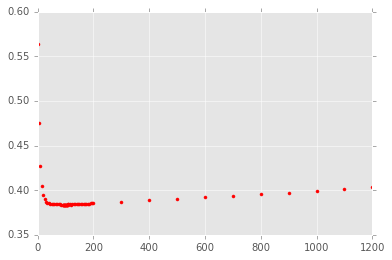

In [13]:
plt.plot(np.array(grid.cv_results_["param_n_estimators"]), grid.cv_results_["mean_test_score"] * -1, '.r')

In [15]:
print grid.best_estimator_.n_estimators, grid.best_score_ * -1

95 0.38375715888


Попробуем отправить что получилось

In [18]:
classifier = GradientBoostingClassifier(n_estimators=95, random_state=11)
classifier.fit(x_train, y_train)
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_95.csv', sep=';', header=None, index=False)

# cv         = 0.38375715888
# mlbootcamp = 0.3846472

#  Отступы

Попробуем сделать следующее:
    - посчитать отступы
    - удалить их из обучающих выборок, из тестовых не удалять
    - провести повторно cv

In [19]:
classifier = GradientBoostingClassifier(n_estimators=95, random_state=11)
classifier.fit(x_train, y_train)
predict_proba = classifier.predict_proba(x_train)

margin = np.zeros(shape=y_train.shape)
y = np.array(y_train) # pandas.core.series.Series => numpy.ndarray
idx0 = y==0
idx1 = y==1

margin[idx0] = predict_proba[idx0,0] - predict_proba[idx0,1]
margin[idx1] = predict_proba[idx1,1] - predict_proba[idx1,0]

plt.hist(margin, 50, normed=1, facecolor='green', alpha=0.75)
plt.draw()

Посчитали отступы. Классификатор 100% не уверен ни в одном из примеров

In [26]:
def cross_validation_logloss(x_train, y_train, classifier, margins, n_splits=5, margin_limit=-2):
    loglosses = []

    X = x_train
    y = y_train
    kf = KFold(n_splits=n_splits) #, shuffle=True

    i=1
    for train_index, test_index in kf.split(x_train):
        print '{}/{}'.format(i, n_splits)
        i=i+1
        
        xx_train, xx_test = x_train.loc[train_index], x_train.loc[test_index]
        yy_train, yy_test = y[train_index], y[test_index]
        margins_train = margins[train_index]

        good_margin_index = margins_train > margin_limit
        
        xx_train = xx_train[good_margin_index]
        yy_train = yy_train[good_margin_index]
        
        classifier.fit(xx_train, yy_train)
        ll = log_loss(yy_test, classifier.predict_proba(xx_test))
    
        loglosses.append(ll)
    
    print loglosses, np.mean(loglosses)
    return np.mean(loglosses)

In [31]:
classifier = GradientBoostingClassifier(n_estimators=95, random_state=11)
cross_validation_logloss(x_train, y_train, classifier, margin, n_splits=3, margin_limit=-0)

1/3
2/3
3/3
[0.88424159009799297, 0.88358104347993371, 0.87645381913276221] 0.881425484237


0.88142548423689637

In [49]:
classifier = GradientBoostingClassifier(n_estimators=95, random_state=11)
limits=np.linspace(-1,0.9,20)
lls=[]
for limit in limits:
    ll = cross_validation_logloss(x_train, y_train, classifier, margin, n_splits=3, margin_limit=limit)
    print ll
    lls.append(ll)

1/3
2/3
3/3
[0.38350533553338101, 0.37840122892319317, 0.38956354118127695] 0.383823368546
0.383823368546
1/3
2/3
3/3
[0.38510465213234496, 0.38183470716473578, 0.3945132737637192] 0.387150877687
0.387150877687
1/3
2/3
3/3
[0.39798018468314816, 0.38973521804678307, 0.40649571576236371] 0.398070372831
0.398070372831
1/3
2/3
3/3
[0.41811387267474082, 0.40669615108278984, 0.42541523882524468] 0.416741754194
0.416741754194
1/3
2/3
3/3
[0.43256318348089912, 0.42298879827028996, 0.44130902089196644] 0.432287000881
0.432287000881
1/3
2/3
3/3
[0.45778851545915566, 0.4492466734438863, 0.46314136838210884] 0.456725519095
0.456725519095
1/3
2/3
3/3
[0.49523830827862003, 0.48463150065883109, 0.50616847591603009] 0.495346094951
0.495346094951
1/3
2/3
3/3
[0.55007873945346386, 0.54262258021531629, 0.56678794028352864] 0.553163086651
0.553163086651
1/3
2/3
3/3
[0.6236682191772307, 0.60722825023567417, 0.63014239937158811] 0.620346289595
0.620346289595
1/3
2/3
3/3
[0.73567200252825427, 0.7283032459147

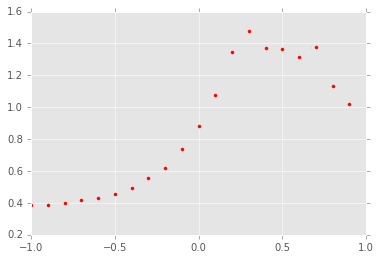

In [50]:
plt.plot(limits, np.array(lls), '.r')

Результатов нет =(

Капнем глубже и повторим поиск для разных значений n_estimators

In [64]:
n_estimators_array = np.concatenate(([1],
                                      range(5,90,5),
                                      range(90,110),
                                      range(110,200,5)))


res = []
for n_estimators in n_estimators_array:
    classifier = GradientBoostingClassifier(n_estimators=n_estimators, random_state=11)
    classifier.fit(x_train, y_train)
    predict_proba = classifier.predict_proba(x_train)

    margin = np.zeros(shape=y_train.shape)
    y = np.array(y_train) # pandas.core.series.Series => numpy.ndarray
    idx0 = y==0
    idx1 = y==1

    margin[idx0] = predict_proba[idx0,0] - predict_proba[idx0,1]
    margin[idx1] = predict_proba[idx1,1] - predict_proba[idx1,0]

    classifier = GradientBoostingClassifier(n_estimators=n_estimators, random_state=11)
    limits=np.linspace(-1,-0.5,20)
    lls=[]
    for limit in limits:
        ll = cross_validation_logloss(x_train, y_train, classifier, margin, n_splits=3, margin_limit=limit)
        print ll
        lls.append(ll)
                                    
    idx = np.argmin(lls)
    
    res.append((limits[idx], lls[idx]))
                                    
print res

1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.56337871333823808, 0.56563879903360526] 0.563180378448
0.563180378448
1/3
2/3
3/3
[0.56052362297306457, 0.5633787133

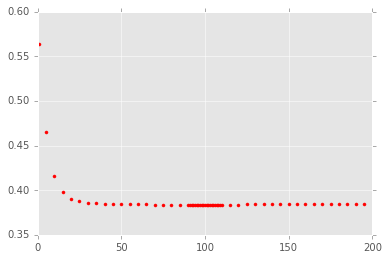

In [72]:
plt.plot(np.array(n_estimators_array), np.array([x[1] for x in res]), '.r')

In [76]:
print n_estimators_array[idx], res[idx]

92 (-1.0, 0.38376479343702136)


Улучшить не удалось

# Калибровка

In [ ]:
x_train_good, y_train_good = x_train[good_idx], y_train[good_idx]
xx_train, yy_train = x_train_good[:limit], y_train_good[:limit]
xx_valid, yy_valid = x_train_good[limit:], y_train_good[limit:]
clf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
clf.fit(xx_train, yy_train)
#clf_probs = clf.predict_proba(xx_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(xx_valid, yy_valid)
#sig_clf_probs = sig_clf.predict_proba(xx_test)
#sig_score = log_loss(yy_test, sig_clf_probs)

In [95]:
def cross_validation_logloss_calibrated(x_train, y_train, classifier, n_splits=5, valid_limit = 0.70):
    loglosses = []

    X = x_train
    y = y_train
    kf = KFold(n_splits=n_splits) #, shuffle=True

    i=1
    for train_index, test_index in kf.split(x_train):
        print '{}/{}'.format(i, n_splits)
        i=i+1
        
        limit_index = int((len(train_index) * valid_limit)) # Граница разбиения тренировочной выборки на тренир и валид
        valid_index = train_index[limit_index :]
        train_index = train_index[: limit_index]
        
        print limit_index
        print valid_index, train_index
        
        xx_train, xx_valid, xx_test = x_train.loc[train_index], x_train.loc[valid_index], x_train.loc[test_index]
        yy_train, yy_valid, yy_test = y[train_index], y[valid_index], y[test_index]
                
        classifier.fit(xx_train, yy_train)
        
        sig_clf = CalibratedClassifierCV(classifier, method="sigmoid", cv="prefit")
        sig_clf.fit(xx_valid, yy_valid)
        
        ll = log_loss(yy_test, sig_clf.predict_proba(xx_test)) #classifier.predict_proba(xx_test))    
        loglosses.append(ll)
    
    print loglosses, np.mean(loglosses)
    return np.mean(loglosses)

In [99]:
classifier = GradientBoostingClassifier(n_estimators=95,
                                        random_state=11,
                                        max_depth=5,
                                        subsample=0.5,
                                        max_features='log2')

print cross_validation_logloss_calibrated(x_train, y_train, classifier)

#0.384535979476

# n_estimators=95,
# random_state=11,
# max_depth=2,
# subsample=0.5,
# max_features='log2'
# 0.385967926516

1/5
14161
[19219 19220 19221 ..., 25286 25287 25288] [ 5058  5059  5060 ..., 19216 19217 19218]
2/5
14161
[19219 19220 19221 ..., 25286 25287 25288] [    0     1     2 ..., 19216 19217 19218]
3/5
14161
[19219 19220 19221 ..., 25286 25287 25288] [    0     1     2 ..., 19216 19217 19218]
4/5
14161
[14161 14162 14163 ..., 25286 25287 25288] [    0     1     2 ..., 14158 14159 14160]
5/5
14162
[14162 14163 14164 ..., 20229 20230 20231] [    0     1     2 ..., 14159 14160 14161]
[0.392773255323008, 0.38211729979037379, 0.3794832881434374, 0.4032649753562933, 0.38047640520036774] 0.387623044763
0.387623044763


In [175]:
# Результатов не дала

In [104]:
classifier = GradientBoostingClassifier(#learning_rate=0.1,
                                        n_estimators=95,
                                        #max_features='sqrt',
                                        #subsample=0.8,
                                        random_state=11)

crossed = cross_val_score(classifier, x_train, y_train, scoring=scorer_logloss, n_jobs=3)

print np.mean(crossed), crossed

0.383757057928 [ 0.38503354  0.37952984  0.38670779]


# Решение с сайта

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [131]:
param_test1 = {'n_estimators':range(10,101,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=11), 
                        param_grid = param_test1,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)
gsearch1.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=500, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=11,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function revert_scorer_logloss at 0x1114b28c0>, verbose=0)

{'n_estimators': 60} -0.383094591282


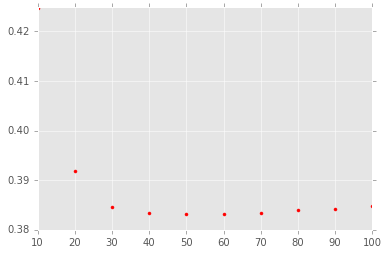

In [133]:
plt.plot(np.array(gsearch1.cv_results_["param_n_estimators"]), gsearch1.cv_results_["mean_test_score"] * -1, '.r')
print gsearch1.best_params_, gsearch1.best_score_

In [135]:
param_test2 = {'max_depth':range(5,16,2),
               'min_samples_split':range(200,1001,200)}

classifier = GradientBoostingClassifier(learning_rate=0.1,
                                        min_samples_leaf=50, # в статье отсутствует
                                        n_estimators=60,
                                        max_features='sqrt',
                                        subsample=0.8,
                                        random_state=11)

gsearch2_2 = GridSearchCV(estimator = classifier,
                        param_grid = param_test2,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)

gsearch2_2.fit(x_train,y_train)
gsearch2_2.best_params_, -gsearch2_2.best_score_

# в статье отсутствовал параметр min_samples_leaf=50
# без него получаем logloss = -0.38337131286907927 ({'max_depth': 5, 'min_samples_split': 600})
# а с ним 0.38279548209828834 ({'max_depth': 11, 'min_samples_split': 800}), что, естественно, лучше

({'max_depth': 11, 'min_samples_split': 800}, 0.38279548209828834)

In [136]:
# В окресности {'max_depth': 11, 'min_samples_split': 800} поищем результат получше
max_depth_opt = 11
min_samples_split_opt = 800

param_test2 = {'max_depth': range(max_depth_opt-2,max_depth_opt+3),
               'min_samples_split':range(min_samples_split_opt-200, min_samples_split_opt+201,50)}

classifier = GradientBoostingClassifier(learning_rate=0.1,
                                        min_samples_leaf=50,
                                        n_estimators=60,
                                        max_features='sqrt',
                                        subsample=0.8,
                                        random_state=11)

gsearch2_3 = GridSearchCV(estimator = classifier,
                        param_grid = param_test2,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)

gsearch2_3.fit(x_train,y_train)
gsearch2_3.best_params_, -gsearch2_3.best_score_

({'max_depth': 9, 'min_samples_split': 950}, 0.38212975831119084)

In [141]:
min_samples_split_opt = 950
max_depth_opt = 9

param_test3 = {'max_depth': range(max_depth_opt-2,max_depth_opt+3),
               'min_samples_split':range(min_samples_split_opt-300, min_samples_split_opt+301,50), #range(1000,2100,200),
               'min_samples_leaf':range(20,81,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=60,
                                                               #max_depth=9,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=11), 
                        param_grid = param_test3,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False, 
                        cv=3)
gsearch3.fit(x_train,y_train)
gsearch3.best_params_, -gsearch3.best_score_

({'max_depth': 9, 'min_samples_leaf': 50, 'min_samples_split': 950},
 0.38212975831119084)

max_depth и min_samples_split не изменились

In [143]:
param_test4 = {'max_features':range(2,13)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=60,
                                                               max_depth=9,
                                                               min_samples_split=950,
                                                               min_samples_leaf=50,
                                                               subsample=0.8,
                                                               random_state=11),
                        param_grid = param_test4,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False, 
                        cv=3)
gsearch4.fit(x_train,y_train)
gsearch4.best_params_, -gsearch4.best_score_

({'max_features': 3}, 0.38212975831119084)

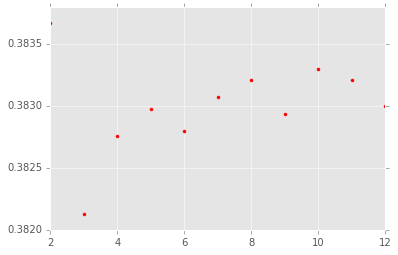

In [144]:
plt.plot(np.array(gsearch4.cv_results_["param_max_features"]), gsearch4.cv_results_["mean_test_score"] * -1, '.r')

Получили такой классификтор (с настройками дерева)
- n_estimators=60,

- max_depth=9,
- min_samples_split=950,
- min_samples_leaf=50
- max_features=3

{'n_estimators': 65} 0.382083185483


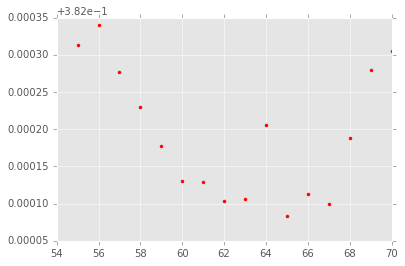

In [147]:
# уточним количество деревьев.
# изменилось с 60 до 65

param_test1 = {'n_estimators':range(55, 71)}#range(10,101,10)}
gsearch1_1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               min_samples_split=950,
                                                               min_samples_leaf=50,
                                                               max_depth=9,
                                                               max_features=3,
                                                               subsample=0.8,
                                                               random_state=11), 
                        param_grid = param_test1,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)
gsearch1_1.fit(x_train, y_train)
print gsearch1_1.best_params_, -gsearch1_1.best_score_
plt.plot(np.array(gsearch1_1.cv_results_["param_n_estimators"]), gsearch1_1.cv_results_["mean_test_score"] * -1, '.r')

In [157]:
np.arange(0.5,0.9,0.1/5.0)

array([ 0.5 ,  0.52,  0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,
        0.68,  0.7 ,  0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,
        0.86,  0.88])

{'subsample': 0.80000000000000027} 0.382083185483


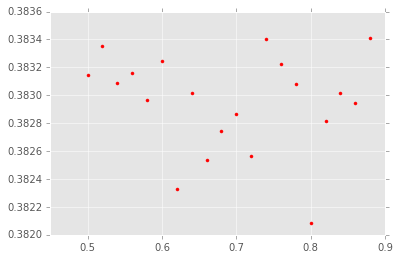

In [158]:
param_test5 = {'subsample': np.arange(0.5,0.9,0.1/5.0)}

gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                                 n_estimators=65,
                                                                 min_samples_split=950,
                                                                 min_samples_leaf=50,
                                                                 max_depth=9,
                                                                 max_features=3,
                                                                 random_state=11), 
                        param_grid = param_test5,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)
gsearch5.fit(x_train, y_train)
print gsearch5.best_params_, -gsearch5.best_score_
plt.plot(np.array(gsearch5.cv_results_["param_subsample"]), gsearch5.cv_results_["mean_test_score"] * -1, '.r')

# subsample - не изменился

In [170]:
learning_rate=0.1
n_estimators=65
fractions=np.array([0.5,1,5,10,15,20]) #,25,30])

param_test6 = {'learning_rate': learning_rate/fractions,
               'n_estimators': np.array(n_estimators*fractions, dtype=int)}

gsearch6 = GridSearchCV(estimator = GradientBoostingClassifier(#learning_rate=0.1,
                                                               #  n_estimators=65,
                                                                 min_samples_split=950,
                                                                 min_samples_leaf=50,
                                                                 max_depth=9,
                                                                 max_features=3,
                                                                 subsample=0.8,
                                                                 random_state=11), 
                        param_grid = param_test6,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)
gsearch6.fit(x_train, y_train)
print gsearch6.best_params_, -gsearch6.best_score_




{'n_estimators': 975, 'learning_rate': 0.0066666666666666671} 0.382005998445


In [174]:
classifier = GradientBoostingClassifier(learning_rate=0.02/3, # 0.00(6)
                                        n_estimators=975,
                                        subsample=0.8,
                                        min_samples_split=950,
                                        min_samples_leaf=50,
                                        max_depth=9,
                                        max_features=3,
                                        random_state=11)
classifier.fit(x_train, y_train)
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_975.csv', sep=';', header=None, index=False)

# cv=0.382005998445
# mlbootcamp=0.3831089

In [40]:
classifier = GradientBoostingClassifier(learning_rate=0.02/3, # 0.00(6)
                                        n_estimators=975,
                                        subsample=0.8,
                                        min_samples_split=950,
                                        min_samples_leaf=50,
                                        max_depth=9,
                                        max_features=3,
                                        random_state=11)
classifier.fit(x_train, y_train)
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
#res_df = pd.DataFrame(y_test, columns = ['y'])
#res_df.to_csv('res/007_gb_n_est_975.csv', sep=';', header=None, index=False)



In [50]:
xx_test = pd.read_csv('data/x_test.csv', sep=';', na_values='?')

df = xx_test[xx_test['maxPlayerLevel']-xx_test['numberOfAttemptedLevels']<=0]
df = df[df['maxPlayerLevel']>86]

y_test[df.index]=1

In [39]:
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_975_hack.csv', sep=';', header=None, index=False)

#hack 1

In [42]:
xx_test = pd.read_csv('data/x_test.csv', sep=';', na_values='?')

df = xx_test[xx_test['maxPlayerLevel']-xx_test['numberOfAttemptedLevels']<=0]
df = df[df['maxPlayerLevel']>86]

y_test[df.index]

array([ 0.93981754,  0.83409846,  0.81239454,  0.94719265,  0.83605289,
        0.95932116,  0.82671599,  0.79180142,  0.96185248,  0.94295588,
        0.95129433,  0.81298726,  0.9603765 ])

In [51]:
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df[res_df['y']>0.95] = 1

In [52]:
res_df[res_df['y']<0.05] = 0

In [53]:
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_975_hack2.csv', sep=';', header=None, index=False)

In [51]:
param_grid = {
    'min_samples_split': range(100, 1001, 100),
    'min_samples_leaf': range(10,151,10),
    'max_depth': range(4, 11),
    'max_features': range(2, 6)}

grid_search = GridSearchCV(
    estimator = GradientBoostingClassifier(
        learning_rate=0.1,
        n_estimators=70,
        subsample=0.8,
        random_state=11), 
    param_grid = param_grid,
    scoring=revert_scorer_logloss,
    n_jobs=3,
    iid=False,
    cv=3)

grid_search.fit(x_train, y_train)
print grid_search.best_params_, -grid_search.best_score_

{'max_features': 4, 'min_samples_split': 800, 'max_depth': 6, 'min_samples_leaf': 100} 0.382008175442


{'subsample': 0.80000000000000027} 0.382008175442


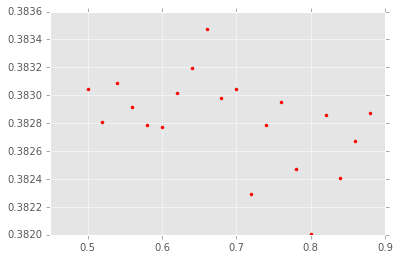

In [53]:
param_grid = {'subsample': np.arange(0.5,0.9,0.1/5.0)}

grid_search_70 = GridSearchCV(
    estimator = GradientBoostingClassifier(
        learning_rate=0.1,
        n_estimators=70,
        #subsample=0.8,
        min_samples_split=800,
        min_samples_leaf=100,
        max_depth=6,
        max_features=4,
        random_state=11), 
    param_grid = param_grid,
    scoring=revert_scorer_logloss,
    n_jobs=3,
    iid=False,
    cv=3)
grid_search_70.fit(x_train, y_train)
print grid_search_70.best_params_, -grid_search_70.best_score_
plt.plot(np.array(grid_search_70.cv_results_["param_subsample"]), grid_search_70.cv_results_["mean_test_score"] * -1, '.r')

# не улучшило

In [56]:
learning_rate=0.1
n_estimators=70
fractions=np.array([20,25,30]) #np.array([0.5,1,5,10,15,20]) #,25,30])

param_grid = {'learning_rate': learning_rate/fractions,
              'n_estimators': np.array(n_estimators*fractions, dtype=int)}

grid_search_70 = GridSearchCV(
    estimator = GradientBoostingClassifier(
        #learning_rate=0.1,
        #n_estimators=70,
        subsample=0.8,
        min_samples_split=800,
        min_samples_leaf=100,
        max_depth=6,
        max_features=4,
        random_state=11), 
    param_grid = param_grid,
    scoring=revert_scorer_logloss,
    n_jobs=3,
    iid=False,
    cv=3)
grid_search_70.fit(x_train, y_train)
print grid_search_70.best_params_, -grid_search_70.best_score_

{'n_estimators': 1750, 'learning_rate': 0.0040000000000000001} 0.381900898568


In [71]:
param_test1 = {'n_estimators':range(55, 81)}#range(10,101,10)}
grid_search_70 = GridSearchCV(
    estimator = GradientBoostingClassifier(
        learning_rate=0.1,
        #n_estimators=70,
        subsample=0.8,
        min_samples_split=800,
        min_samples_leaf=100,
        max_depth=6,
        max_features=4,
        random_state=11), 
    param_grid = param_test1,
    scoring=revert_scorer_logloss,
    n_jobs=3,
    iid=False,
    cv=3)
grid_search_70.fit(x_train, y_train)
print grid_search_70.best_params_, -grid_search_70.best_score_

{'n_estimators': 64} 0.381954918824


In [50]:
# param_grid = {
#     'min_samples_split': range(100, 1001, 100),
#     'min_samples_leaf': range(10,151,10),
#     'max_depth': range(4, 11),
#     'max_features': range(2, 6)}
# res = 1
# for el in [len(param_grid[key]) for key in param_grid]:
#     res=res * el
# print res / (980.0 * 2) # общет деревьев за полчаса (кол-во деревьев 70) 980

2.14285714286


In [60]:
classifier = GradientBoostingClassifier(learning_rate=0.004,
                                        n_estimators=1750,
                                        subsample=0.8,
                                        min_samples_split=800,
                                        min_samples_leaf=100,
                                        max_depth=6,
                                        max_features=4,
                                        random_state=11)
classifier.fit(x_train, y_train)
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_1750.csv', sep=';', header=None, index=False)

# cv         = 0.381900898568
# mlbootcamp = 0.3835180

In [61]:
classifier = GradientBoostingClassifier(learning_rate=0.1,
                                        n_estimators=70,
                                        subsample=0.8,
                                        min_samples_split=800,
                                        min_samples_leaf=100,
                                        max_depth=6,
                                        max_features=4,
                                        random_state=11)
classifier.fit(x_train, y_train)
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_70.csv', sep=';', header=None, index=False)

# cv         = 0.382008175442
# mlbootcamp = 0.3840014

In [79]:
param_grid = {
    'n_estimators': range(20, 100, 10),
    'min_samples_split': range(100, 1001, 100),
    'min_samples_leaf': range(10,151,10),
    'max_depth': range(4, 11),
    'max_features': range(2, 6)}

grid_search = GridSearchCV(
    estimator = GradientBoostingClassifier(
        learning_rate=0.1,
        subsample=0.8,
        random_state=10),   # 10!!!
    param_grid = param_grid,
    scoring=revert_scorer_logloss,
    n_jobs=3,
    iid=False,
    cv=3)

grid_search.fit(x_train, y_train)
print grid_search.best_params_, -grid_search.best_score_

# {'max_features': 4, 'min_samples_split': 400, 'n_estimators': 60, 'max_depth': 5, 'min_samples_leaf': 140}
# 0.381879368378

{'max_features': 4, 'min_samples_split': 400, 'n_estimators': 60, 'max_depth': 5, 'min_samples_leaf': 140} 0.381879368378


In [70]:
# param_grid = {
# #    'subsample':[0.6,0.8],
#     'n_estimators': range(20, 100, 10),
#     'min_samples_split': range(100, 1001, 100),
#     'min_samples_leaf': range(10,151,10),
#     'max_depth': range(4, 11),
#     'max_features': range(2, 6)}
# res = 1
# for el in [len(param_grid[key]) for key in param_grid]:
#     res=res * el
# print res / (980.0 * 2) # общет деревьев за полчаса (кол-во деревьев 70) 980

17.1428571429


In [78]:
learning_rate=0.1
n_estimators=64
fractions=np.array([0.5,1,5,10,15,20,25,30])

[{'learning_rate': [learning_rate/frac], 'n_estimators': [int(n_estimators*frac)]} for frac in fractions]

[{'learning_rate': [0.20000000000000001], 'n_estimators': [32]},
 {'learning_rate': [0.10000000000000001], 'n_estimators': [64]},
 {'learning_rate': [0.02], 'n_estimators': [320]},
 {'learning_rate': [0.01], 'n_estimators': [640]},
 {'learning_rate': [0.0066666666666666671], 'n_estimators': [960]},
 {'learning_rate': [0.0050000000000000001], 'n_estimators': [1280]},
 {'learning_rate': [0.0040000000000000001], 'n_estimators': [1600]},
 {'learning_rate': [0.0033333333333333335], 'n_estimators': [1920]}]

In [77]:
classifier = GradientBoostingClassifier(learning_rate=0.004,
                                        n_estimators=1600,
                                        subsample=0.8,
                                        min_samples_split=800,
                                        min_samples_leaf=100,
                                        max_depth=6,
                                        max_features=4,
                                        random_state=11)
classifier.fit(x_train, y_train)
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_1600.csv', sep=';', header=None, index=False)

# cv = 0.381924300151
# mlbootcamp = 0.3835060

In [84]:
pd.DataFrame(grid_search.cv_results_).sort(['split2_test_score'], ascending=[False])

/Users/kurtov/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
8156,1.051164,0.024355,-0.382192,-0.369846,5,4,120,1000,60,"{u'max_features': 4, u'min_samples_split': 100...",...,-0.382433,-0.370820,-0.379462,-0.370824,-0.384681,-0.367893,0.051943,0.004383,0.002137,0.001381
7868,1.108131,0.023923,-0.382204,-0.364310,5,4,90,400,60,"{u'max_features': 4, u'min_samples_split': 400...",...,-0.382709,-0.365734,-0.379186,-0.365074,-0.384717,-0.362123,0.017549,0.000905,0.002286,0.001570
7867,0.898740,0.019709,-0.382273,-0.366473,5,4,90,400,50,"{u'max_features': 4, u'min_samples_split': 400...",...,-0.383027,-0.367689,-0.379066,-0.367159,-0.384728,-0.364572,0.068106,0.000868,0.002372,0.001362
15387,1.177658,0.030797,-0.382813,-0.363953,7,2,130,400,50,"{u'max_features': 2, u'min_samples_split': 400...",...,-0.383618,-0.364866,-0.380081,-0.365271,-0.384741,-0.361722,0.066996,0.000320,0.001986,0.001586
23418,1.326978,0.024975,-0.382714,-0.366399,8,5,80,800,40,"{u'max_features': 5, u'min_samples_split': 800...",...,-0.383089,-0.366868,-0.380309,-0.367949,-0.384745,-0.364378,0.010927,0.002736,0.001830,0.001495
7523,1.136836,0.022424,-0.382461,-0.361520,5,4,50,100,50,"{u'max_features': 4, u'min_samples_split': 100...",...,-0.383032,-0.363115,-0.379535,-0.362472,-0.384816,-0.358973,0.042646,0.000313,0.002193,0.001820
26194,1.278692,0.028995,-0.382560,-0.364293,9,3,130,500,40,"{u'max_features': 3, u'min_samples_split': 500...",...,-0.382597,-0.365108,-0.380253,-0.365560,-0.384830,-0.362212,0.065668,0.002008,0.001868,0.001483
8268,1.045905,0.019577,-0.381879,-0.365331,5,4,140,400,60,"{u'max_features': 4, u'min_samples_split': 400...",...,-0.382123,-0.366687,-0.378672,-0.366244,-0.384843,-0.363061,0.015447,0.001792,0.002525,0.001615
26707,1.378868,0.028344,-0.382724,-0.362602,9,4,40,900,50,"{u'max_features': 4, u'min_samples_split': 900...",...,-0.383695,-0.363012,-0.379627,-0.363847,-0.384850,-0.360946,0.013801,0.000783,0.002240,0.001219
31666,1.158608,0.023604,-0.382516,-0.366205,10,4,60,900,40,"{u'max_features': 4, u'min_samples_split': 900...",...,-0.382690,-0.366467,-0.380000,-0.367096,-0.384858,-0.365053,0.054392,0.000347,0.001987,0.000854


In [85]:
res_df = pd.DataFrame(grid_search.cv_results_)
res_df.to_csv('data/gb_learning_rate=0.1,subsample=0.8,random_state=10.csv', sep=';')

In [119]:
param_test1 = {'n_estimators':range(40,70,), 'random_state':[3,5,7,9,11]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=11), 
                        param_grid = param_test1,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)
gsearch1.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=500, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=11,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69], 'random_state': [3, 5, 7, 9, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function revert_scorer_logloss at 0x111c369b0>, verbose=0)

{'n_estimators': 53, 'random_state': 11} 0.382947612483
param_n_estimators    58.000000
mean_test_score        0.383389
Name: 18, dtype: float64


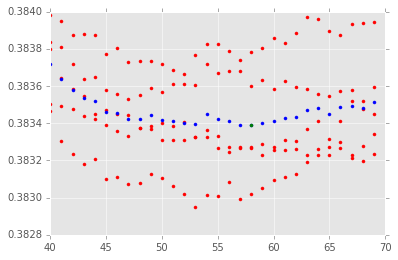

In [136]:
print gsearch1.best_params_, -gsearch1.best_score_
plt.plot(np.array(gsearch1.cv_results_["param_n_estimators"]), gsearch1.cv_results_["mean_test_score"] * -1, '.r')

df = pd.DataFrame(gsearch1.cv_results_)
df = df[["param_n_estimators", "mean_test_score"]].groupby(['param_n_estimators'],as_index=False).mean()
df['mean_test_score'] = df['mean_test_score'] * -1
plt.plot(df['param_n_estimators'], df["mean_test_score"], '.b')

min_val = df.loc[df.idxmin()['mean_test_score']]
plt.plot(min_val['param_n_estimators'], min_val["mean_test_score"], '.g')

print min_val

In [134]:
df.loc[df.idxmin()['mean_test_score']]

param_n_estimators    58.000000
mean_test_score        0.383389
Name: 18, dtype: float64

In [138]:
param_test2 = {'max_depth':range(5,16,2),
               'min_samples_split':range(300,1101,100),
               'random_state':[3,5,7,9,11]}

classifier = GradientBoostingClassifier(learning_rate=0.1,
                                        min_samples_leaf=50,
                                        n_estimators=58,
                                        max_features='sqrt',
                                        subsample=0.8,
                                        random_state=11)

gsearch2_2 = GridSearchCV(estimator = classifier,
                        param_grid = param_test2,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)

gsearch2_2.fit(x_train,y_train)
gsearch2_2.best_params_, -gsearch2_2.best_score_

({'max_depth': 9, 'min_samples_split': 900, 'random_state': 3},
 0.38231464331008874)

In [178]:
def fn_min_val(grid, columns):
    ex_col = np.concatenate([columns, ["mean_test_score"]])
    df = pd.DataFrame(grid.cv_results_)
    df['mean_test_score'] = df['mean_test_score'] * -1
    df = df[ex_col].groupby(columns,as_index=False).mean()

    return df.loc[df.idxmin()['mean_test_score']]

min_val = fn_min_val(gsearch2_2, ["param_max_depth", "param_min_samples_split"])

In [179]:
min_val

param_max_depth               9.000000
param_min_samples_split    1000.000000
mean_test_score               0.382875
Name: 25, dtype: float64

In [151]:
param_test3 = {'min_samples_leaf':range(20,81,10), 'random_state':[3,5,7,9,11]}

classifier = GradientBoostingClassifier(learning_rate=0.1,
                                        min_samples_leaf=50,
                                        max_depth=9,
                                        min_samples_split=1000,
                                        n_estimators=58,
                                        max_features='sqrt',
                                        subsample=0.8,
                                        random_state=11)

gsearch3 = GridSearchCV(estimator = classifier,
                        param_grid = param_test3,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)

gsearch3.fit(x_train,y_train)
gsearch3.best_params_, -gsearch3.best_score_

({'min_samples_leaf': 50, 'random_state': 3}, 0.38253703429975022)

{'random_state': 3, 'min_samples_leaf': 50} 0.3825370343
param_min_samples_leaf    70.000000
mean_test_score            0.382864
Name: 5, dtype: float64


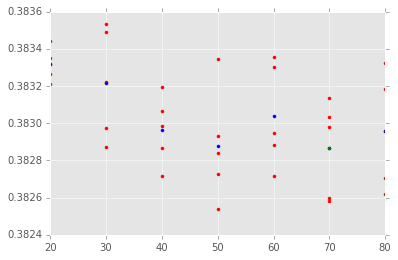

In [154]:
print gsearch3.best_params_, -gsearch3.best_score_
plt.plot(np.array(gsearch3.cv_results_["param_min_samples_leaf"]), gsearch3.cv_results_["mean_test_score"] * -1, '.r')

df = pd.DataFrame(gsearch3.cv_results_)
df = df[["param_min_samples_leaf", "mean_test_score"]].groupby(['param_min_samples_leaf'],as_index=False).mean()
df['mean_test_score'] = df['mean_test_score'] * -1
plt.plot(df['param_min_samples_leaf'], df["mean_test_score"], '.b')

min_val = df.loc[df.idxmin()['mean_test_score']]
plt.plot(min_val['param_min_samples_leaf'], min_val["mean_test_score"], '.g')

print min_val

In [156]:
param_test4 = {'max_features':range(2,13), 'random_state':[3,5,7,9,11]}

classifier = GradientBoostingClassifier(learning_rate=0.1,
                                        min_samples_leaf=70,
                                        max_depth=9,
                                        min_samples_split=1000,
                                        n_estimators=58,
                                        max_features='sqrt',
                                        subsample=0.8,
                                        random_state=11)

gsearch4 = GridSearchCV(estimator = classifier,
                        param_grid = param_test4,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)

gsearch4.fit(x_train,y_train)
gsearch4.best_params_, -gsearch4.best_score_

({'max_features': 11, 'random_state': 9}, 0.38240778261137248)

In [157]:
def show_plt(grid, column):
    print grid.best_params_, -grid.best_score_
    plt.plot(np.array(grid.cv_results_[column]), grid.cv_results_["mean_test_score"] * -1, '.r')

    df = pd.DataFrame(grid.cv_results_)
    df = df[[column, "mean_test_score"]].groupby([column],as_index=False).mean()
    df['mean_test_score'] = df['mean_test_score'] * -1
    plt.plot(df[column], df["mean_test_score"], '.b')

    min_val = df.loc[df.idxmin()['mean_test_score']]
    plt.plot(min_val[column], min_val["mean_test_score"], '.g')

    print min_val

{'max_features': 11, 'random_state': 9} 0.382407782611
param_max_features    4.000000
mean_test_score       0.382673
Name: 2, dtype: float64


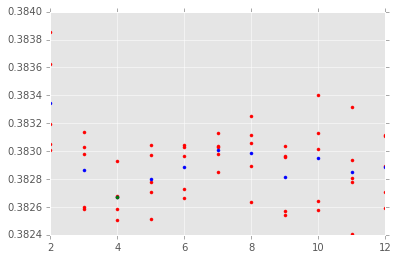

In [158]:
show_plt(gsearch4, 'param_max_features')

Получили такой классификтор (с настройками дерева)
- n_estimators=58,

- max_depth=9,
- min_samples_split=1000,
- min_samples_leaf=70
- max_features=4

In [161]:
learning_rate=0.1
n_estimators=58
fractions=np.array([0.5,1,5,10,15,20,25,30])

param_test5 = [{
        'learning_rate': [learning_rate/frac],
        'n_estimators': [int(n_estimators*frac)],
        'random_state':[3,5,7,9,11]
} for frac in fractions]

classifier = GradientBoostingClassifier(learning_rate=0.1,
                                        min_samples_leaf=70,
                                        max_depth=9,
                                        min_samples_split=1000,
                                        n_estimators=58,
                                        max_features=4,
                                        subsample=0.8,
                                        random_state=11)

gsearch5 = GridSearchCV(estimator = classifier,
                        param_grid = param_test5,
                        scoring=revert_scorer_logloss,
                        n_jobs=4,
                        iid=False,
                        cv=3)

gsearch5.fit(x_train,y_train)
gsearch5.best_params_, -gsearch4.best_score_

({'learning_rate': 0.02, 'n_estimators': 290, 'random_state': 5},
 0.38240778261137248)

In [181]:
min_val = fn_min_val(gsearch5, ["param_learning_rate", "param_n_estimators"])
print min_val

param_learning_rate      0.01000
param_n_estimators     580.00000
mean_test_score          0.38202
Name: 4, dtype: float64


In [184]:
classifier = GradientBoostingClassifier(learning_rate=0.01,
                                        min_samples_leaf=70,
                                        max_depth=9,
                                        min_samples_split=1000,
                                        n_estimators=580,
                                        max_features=4,
                                        subsample=0.8,
                                        random_state=5)
classifier.fit(x_train, y_train)
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_70.csv', sep=';', header=None, index=False)

In [6]:
param_grid = {
    'subsample': [0.7,0.6,0.9],
    'n_estimators': range(40, 100, 10),
    'min_samples_split': range(100, 1001, 100),
    'min_samples_leaf': range(30,151,10),
    'max_depth': range(4, 11),
    'max_features': [3,4]}

grid_search = GridSearchCV(
    estimator = GradientBoostingClassifier(
        learning_rate=0.1,
        random_state=11),
    param_grid = param_grid,
    scoring=revert_scorer_logloss,
    n_jobs=4,
    iid=False,
    cv=3)

grid_search.fit(x_train, y_train)
print grid_search.best_params_, -grid_search.best_score_

{'min_samples_leaf': 150, 'n_estimators': 60, 'subsample': 0.9, 'min_samples_split': 800, 'max_features': 4, 'max_depth': 9} 0.381976798329


In [7]:
res_df = pd.DataFrame(grid_search.cv_results_)
res_df.to_csv('data/gb_learning_rate=0.1,random_state=11.csv', sep=';')

In [8]:
#'subsample': 0.8 {'max_features': 4, 'min_samples_split': 400, 'n_estimators': 60, 'max_depth': 5, 'min_samples_leaf': 140} 0.381879368378

In [9]:
classifier = GradientBoostingClassifier(
    min_samples_leaf=150,
    n_estimators= 60,
    subsample= 0.9, 
    min_samples_split= 800, 
    max_features= 4,
    max_depth= 9,
    learning_rate=0.1,
    random_state=11)

classifier.fit(x_train, y_train)
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_60.csv', sep=';', header=None, index=False)

# cv         = 0.3819767
# mlbootcamp = 0.3839789

In [6]:
x_train[x_train['numberOfDaysActuallyPlayed']==4.1041889169000001]

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed,doReturnOnLowerLevels
173,4.678347,0.045266,2.341868,5.298216,2.465345,1.839732,-1.045041,-0.317750,-0.399114,-0.200961,4.104189,1
301,4.678347,0.122495,3.245016,2.148801,2.124464,1.839732,-0.312632,-0.283296,-0.133514,-0.064579,4.104189,0
1074,3.379320,1.435394,0.987145,4.769115,1.247606,0.928916,-0.432480,1.450008,1.460087,1.503815,4.104189,0
1360,3.029581,0.740330,8.212332,4.718724,1.431729,-0.285504,-0.507941,0.834841,0.709478,0.719618,4.104189,0
1470,1.980367,-0.031963,2.191343,3.408567,1.290233,2.750547,-0.904928,-0.324523,-0.341375,-0.269152,4.104189,1
2352,4.228684,2.284917,0.234522,6.306029,1.056912,4.116770,-0.170727,1.201762,1.875809,1.947056,4.104189,1
2360,1.830479,0.354183,0.083997,1.518917,1.030527,2.295139,-0.341928,0.064778,-0.121966,0.003612,4.104189,1
2645,4.678347,0.972018,2.793442,5.398998,1.077095,0.473509,-0.092909,0.265613,-0.052679,0.583236,4.104189,1
3001,4.328609,1.126477,1.890294,3.635325,1.221759,3.357757,-0.692399,0.661393,1.194487,1.162859,4.104189,0
3057,4.678347,0.122495,3.094492,6.054076,1.997159,1.991534,-0.784629,-0.293308,-0.191253,-0.132770,4.104189,0


In [68]:
classifier = GradientBoostingClassifier(learning_rate=0.02/3, # 0.00(6)
                                        n_estimators=975,
                                        subsample=0.8,
                                        min_samples_split=950,
                                        min_samples_leaf=50,
                                        max_depth=9,
                                        max_features=3,
                                        random_state=11)
classifier.fit(x_train, y_train)
y_test = classifier.predict_proba(x_test)[:,1]

In [115]:
xx_test = pd.read_csv('data/x_test.csv', sep=';', na_values='?')

In [70]:
df = xx_test[xx_test['maxPlayerLevel']-xx_test['numberOfAttemptedLevels']<=0]
df = df[df['maxPlayerLevel']>86]

y_test[df.index]=1

In [71]:
df = xx_test[xx_test['numberOfDaysActuallyPlayed']==14]

y_test[df.index]=1

In [15]:
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_975_hack3.csv', sep=';', header=None, index=False)
#mlbootcamp = 0,3829279

In [27]:
df = xx_test[xx_test['numberOfDaysActuallyPlayed']==13]
# ограничим снизу величиной 176./178
y_test[df.index] = np.maximum(y_test[df.index], np.array([176./178 for x in np.zeros(df.shape[0])]))

In [28]:
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_975_hack4.csv', sep=';', header=None, index=False)
#mlbootcamp = 0,3834491 хуже!

In [41]:
# последовательные игрогки
#data_train.loc[xx_test['maxPlayerLevel']-xx_test['numberOfAttemptedLevels']<=0, 'isSequenceOverMaxLevel']=1
df=xx_test.loc[xx_test['maxPlayerLevel']-xx_test['numberOfAttemptedLevels']<=0] #, 'isSequenceOverMaxLevel']=1
df=df[df['numberOfDaysActuallyPlayed']==13]

y_test[df.index]=1

In [42]:
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_975_hack5.csv', sep=';', header=None, index=False)
#mlbootcamp = 0,3955936 хуже 4-го!

In [57]:
xx_train = pd.read_csv('data/x_train.csv', sep=';', na_values='?')
xx_train['y']=y_train
xx_train_first_weak=xx_train[xx_train['numberOfDaysActuallyPlayed'] < 7]

limits=xx_train_first_weak[xx_train_first_weak['y']==1].groupby('numberOfDaysActuallyPlayed', as_index=False).max()[['numberOfDaysActuallyPlayed', 'attemptsOnTheHighestLevel']]

# 'numberOfDaysActuallyPlayed', 'attemptsOnTheHighestLevel'

In [56]:
xx_train = pd.read_csv('data/x_train.csv', sep=';', na_values='?')
xx_train['y']=y_train
xx_train_first_weak=xx_train[xx_train['numberOfDaysActuallyPlayed'] < 7]

xx_train_first_weak.groupby('numberOfDaysActuallyPlayed', as_index=False).max()[['numberOfDaysActuallyPlayed', 'attemptsOnTheHighestLevel']]

# 'numberOfDaysActuallyPlayed', 'attemptsOnTheHighestLevel'

,numberOfDaysActuallyPlayed,attemptsOnTheHighestLevel
0,1,14
1,2,25
2,3,58
3,4,43
4,5,88
5,6,60


In [119]:
xx_test['y']=y_test
xx_test_first_weak = pd.merge(xx_test, limits, how='left', on='numberOfDaysActuallyPlayed')
xx_test_first_weak = xx_test_first_weak[xx_test_first_weak['numberOfDaysActuallyPlayed'] < 7]

In [130]:
df=xx_test_first_weak[xx_test_first_weak['attemptsOnTheHighestLevel_x'] > xx_test_first_weak['attemptsOnTheHighestLevel_y']]

df = df[df['y']<0.5]
#yyy=pd.Series(y_test[df.index])
#df#['y']  #=pd.Series(y_test[df.index])
#1
y_test[df.index]=0

In [131]:
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_975_hack6.csv', sep=';', header=None, index=False)

#0,3828164
# Лучше

In [132]:
df=xx_test_first_weak[xx_test_first_weak['attemptsOnTheHighestLevel_x'] > xx_test_first_weak['attemptsOnTheHighestLevel_y']]

#df = df[df['y']<0.5]
#yyy=pd.Series(y_test[df.index])
#df#['y']  #=pd.Series(y_test[df.index])
#1
y_test[df.index]=0

In [133]:
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/007_gb_n_est_975_hack7.csv', sep=';', header=None, index=False)

#очень плохо

In [136]:
df=xx_test_first_weak[xx_test_first_weak['attemptsOnTheHighestLevel_x'] > xx_test_first_weak['attemptsOnTheHighestLevel_y']+2]

df

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel_x,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed,y,attemptsOnTheHighestLevel_y
1905,21,22,21,44,17.238095,0,15,0.466667,4777000,3550,47,2,0.260215,17.0
3085,35,1,20,20,0.000000,0,2,0.000000,0,0,0,2,0.342733,17.0
4800,21,22,41,86,17.285714,0,11,0.454545,3762000,2975,43,4,0.627993,38.0
6155,50,51,24,122,18.901639,1,17,0.764706,15501000,9275,121,2,0.681176,17.0
6614,33,34,56,116,17.969697,0,19,0.421053,8741000,5675,77,5,0.839344,46.0
6945,58,59,73,171,19.600000,1,19,0.842105,15313000,10100,133,5,0.798240,46.0
9915,49,1,29,29,0.000000,0,3,0.000000,0,0,0,2,0.343655,17.0
11245,55,1,32,32,15.666667,1,2,1.000000,330000,0,1,3,0.347843,29.0
11682,99,1,29,29,0.000000,0,3,0.000000,0,0,0,2,0.322979,17.0
12368,50,13,43,74,21.166667,0,8,0.375000,1962000,1800,23,4,0.647133,38.0
